# This is a short notebook where we define and run an algorithm simulating the invasion of a population of species X by a population of species Y.

## First, we import the required libraries

In [1]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
from copy import deepcopy

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals

## Then we define the "invasion" function

In [2]:
# create output path
output_dir = "output_4"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        
        def dydt(t, Y):
            nonlocal X_values 
            X_values.append(X.copy()) # record X
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values) 

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Y_tot
        #for t, y in zip(sol.t, sol.y.sum(axis=0)):
        #    resY.write(f"{t:.3f} {y:.3f}\n")

        df_Y = pd.DataFrame({'Time': sol.t, 'Y_total': sol.y.sum(axis=0)})
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_Y.to_csv(file_path, sep=" ", index=False, header=False)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival


## Now, we define parameters and run the code itself

In [3]:
# Define parameters
ttot1 = 200.0  # Total simulation time
dt1 = 1.0E-3  # Timestep
REALIZATIONS1 = 15  # Number of simulation runs
N_X1 = 4  # Number of original species
N_Y1 = 4  # Number of invaders
N_RY1 = 8  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival = invasion_thermo(N_X = N_X1, N_Y = N_Y1, N_RY = N_RY1, ttot = ttot1, dt = dt1, REALIZATIONS = REALIZATIONS1, diluted = False, ambiguity = False, law = "MM", autonomy = True, degradation=False)

Matrix Stot 0:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0
3  0  1  0  0  0  0  0  0
4  0  0  0  0 -1  0  0  1
5 -1  0  0  0  2  0  0  1
6  0 -1  1  0 -1 -1  1 -1
7  1 -1  1  1  0  0 -1  0
8 -1  1 -1 -1  0  1  0  0
#Species:  8 # Reactions:  8
#Species:  8 # Reactions:  8
Generating Autocatalytic Cycles...
Restricted license - for non-production use only - expires 2026-11-23
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_6', 'C_7', 'C_8']
	 Reactions in AC:  ['R3', 'R6', 'R7']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R3: C_8 ->C_6+C_7
			 R6: C_6 ->C_8
			 R7: C_7 ->C_6
	 - CPU Time: 0.02 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  2 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C_4', 'C_8']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_5', 'C_6', 'C_7']
	 Reactions in AC:  ['R1',

## Finally, we plot all the time series

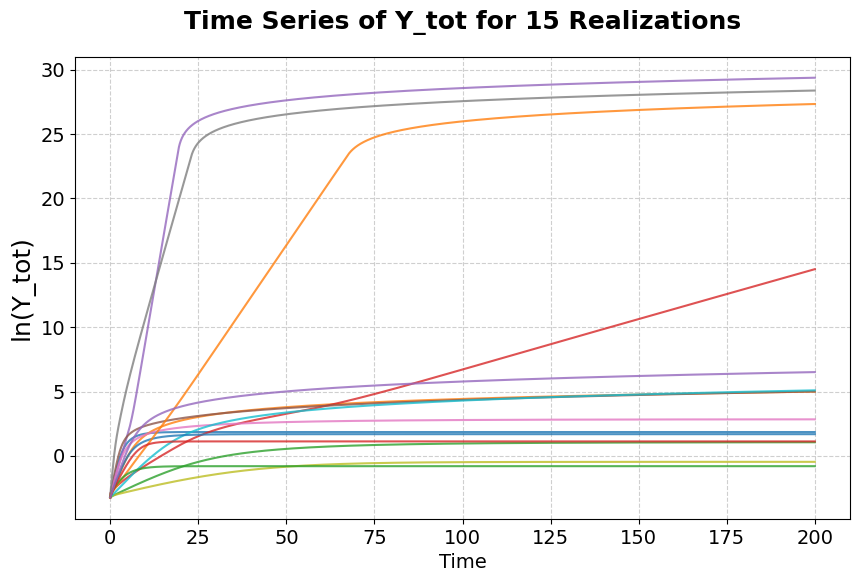

In [4]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each file and plot its time series
data = []
for file in file_list:
    # Read the data
    data = pd.read_csv(file, sep=' ', header=None, names=['Time', 'Y_tot'])
    # Plot each realization
    plt.plot(data['Time'], np.log(data['Y_tot']), linewidth=1.5, alpha=0.8)

# Add title and labels
plt.title(f'Time Series of Y_tot for {len(file_list)} Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y_tot)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



# Change Parameter (non-dilute)

In [5]:
# create output path
output_dir = "output_2"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        
        def dydt(t, Y):
            nonlocal X_values 
            X_values.append(X.copy()) # record X
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values) 

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Y_tot
        #for t, y in zip(sol.t, sol.y.sum(axis=0)):
        #    resY.write(f"{t:.3f} {y:.3f}\n")

        df_Y = pd.DataFrame({'Time': sol.t, 'Y_total': sol.y.sum(axis=0)})
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_Y.to_csv(file_path, sep=" ", index=False, header=False)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival


In [6]:
# Define parameters
ttot2 = 200.0  # Total simulation time
dt2 = 1.0E-3  # Timestep
REALIZATIONS2 = 10  # Number of simulation runs
N_X2 = 3  # Number of original species
N_Y2 = 3  # Number of invaders
N_RY2 = 4  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival2 = invasion_thermo(N_X = N_X2, N_Y = N_Y2, N_RY = N_RY2, ttot = ttot2, dt = dt2, REALIZATIONS = REALIZATIONS2, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
   1  2  3  4
1  1  0  0  0
2  0  0  0 -1
3  0  0  0  0
4  0  1 -2  1
5  1 -1  0 -1
6 -1  0  1  0
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 1:
   1  2  3  4
1  0  0  0  1
2  0  0  0  0
3  0  0 -1  0
4 -2 -1  0 -1
5  1  0 -1  0
6  0  1  1  1
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 2:
   1  2  3  4
1  0  1 -1  0
2  0  0  0 -1
3  1  0  0  0
4  1  1  1  0
5 -1  0  0  1
6  0 -1 -1 -1
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

NOT-Invaded

Matrix Stot 3:
   1  2  3  4
1  0  0 -1  1
2  0 -1  0  0
3  0  

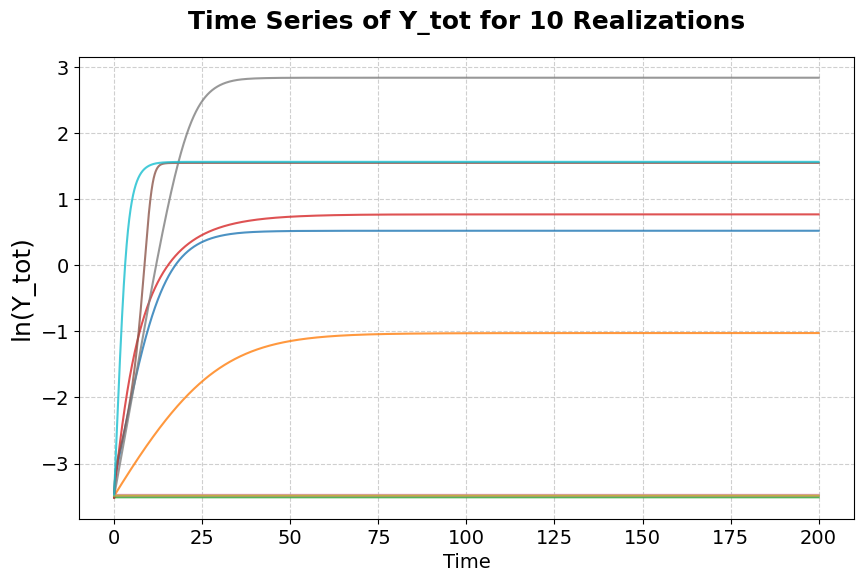

In [7]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each file and plot its time series
data = []
for file in file_list:
    # Read the data
    data = pd.read_csv(file, sep=' ', header=None, names=['Time', 'Y_tot'])
    # Plot each realization
    plt.plot(data['Time'], np.log(data['Y_tot']), linewidth=1.5, alpha=0.8)

# Add title and labels
plt.title(f'Time Series of Y_tot for {len(file_list)} Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y_tot)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()




# Study Single Realization

In [8]:
# create output path
output_dir = "output_single2"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        
        def dydt(t, Y):
            nonlocal X_values 
            X_values.append(X.copy()) # record X
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values) 

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Single Y species
        # for t, y_values in zip(sol.t, sol.y.T):
        #    resY.write(f"{t:.3f}" + "," +",".join(f"{y:.3f}" for y in y_values) + "\n")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [9]:
# Define parameters
ttot3 = 200.0  # Total simulation time
dt3 = 1.0E-3  # Timestep
REALIZATIONS3 = 1  # Number of simulation runs
N_X3 = 5  # Number of original species
N_Y3 = 5  # Number of invaders
N_RY3 = 4  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival3 = Single_Invasion(N_X = N_X3, N_Y = N_Y3, N_RY = N_RY3, ttot = ttot3, dt = dt3, REALIZATIONS = REALIZATIONS3, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1  2  3  4
1   0  0  0  0
2   0  0  0  0
3   0  0  0  0
4   1  0  0  0
5   0  0  0  0
6   0  0  0  2
7   1  2  0 -2
8  -1  0 -1  0
9   0 -1  0  0
10  0  0  1  0
#Species:  10 # Reactions:  4
#Species:  10 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n5.xlsx
X MAINTAINS

<bound method NDFrame.head of            Time       Y_1       Y_2       Y_3       Y_4       Y_5
0         0.000  0.009816  0.010174  0.010374  0.010466  0.010064
1         0.001  0.009814  0.010217  0.010372  0.010446  0.010066
2         0.002  0.009811  0.010260  0.010370  0.010425  0.010069
3         0.003  0.009809  0.010303  0.010368  0.010405  0.010072
4         0.004  0.009806  0.010346  0.010365  0.010384  0.010074
...         ...       ...       ...       ...       ...       ...
199995  199.996  0.006371  0.017467  0.017693  0.000040  0.019749
199996  199.997  0.006371  0.017467  0.017693  0.000040  0.019749
199997 

    Time       Y_1       Y_2       Y_3       Y_4       Y_5
0  0.000  0.009816  0.010174  0.010374  0.010466  0.010064
1  0.001  0.009814  0.010217  0.010372  0.010446  0.010066
2  0.002  0.009811  0.010260  0.010370  0.010425  0.010069
3  0.003  0.009809  0.010303  0.010368  0.010405  0.010072
4  0.004  0.009806  0.010346  0.010365  0.010384  0.010074


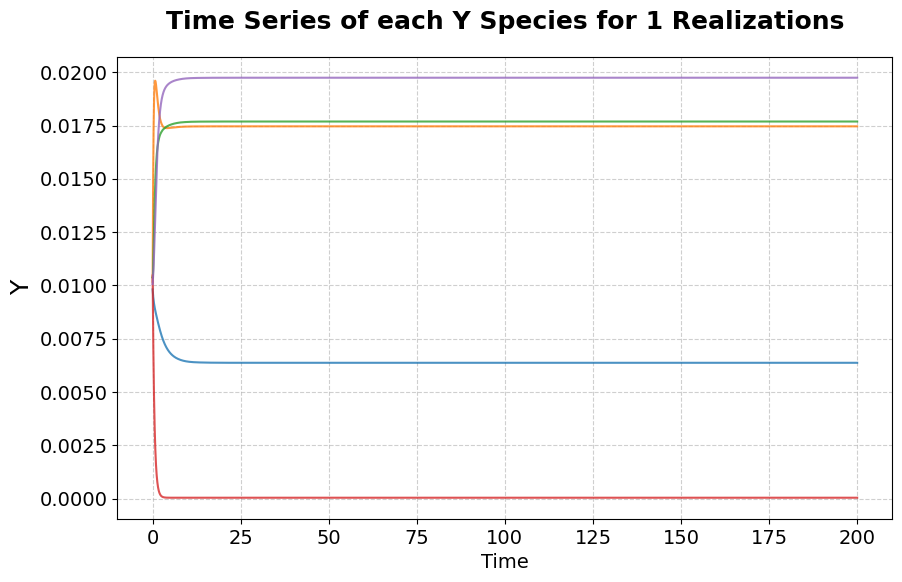

In [10]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)

'''
# Extract Time
time = data.iloc[:, 0]

# Loop through each species and plot its time series
for i in range(1, data.shape[1]):  
    plt.plot(time, data.iloc[:, i], label=f"Y{i}")
'''     

# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [11]:
# Define parameters
ttot3 = 200.0  # Total simulation time
dt3 = 1.0E-3  # Timestep
REALIZATIONS3 = 1  # Number of simulation runs
N_X3 = 5  # Number of original species
N_Y3 = 5  # Number of invaders
N_RY3 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival5 = Single_Invasion(N_X = N_X3, N_Y = N_Y3, N_RY = N_RY3, ttot = ttot3, dt = dt3, REALIZATIONS = REALIZATIONS3, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1  2  3  4  5
1  -1  0  0  0  0
2   0  0  0  0  0
3   0  0  0  0  0
4   0  0  0  0 -1
5   0  0  0  0  0
6  -1  1  0  1 -1
7   1  1  1 -1  0
8   0 -1  0  0  0
9   0  0 -1  0  1
10  1  0  0  1  0
#Species:  10 # Reactions:  5
#Species:  10 # Reactions:  5
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n5.xlsx
X MAINTAINS

<bound method NDFrame.head of            Time       Y_1       Y_2       Y_3       Y_4       Y_5
0         0.000  0.010022  0.010359  0.010382  0.010294  0.009510
1         0.001  0.009992  0.010406  0.010361  0.010319  0.009568
2         0.002  0.009961  0.010452  0.010341  0.010343  0.009627
3         0.003  0.009931  0.010499  0.010320  0.010367  0.009686
4         0.004  0.009900  0.010546  0.010300  0.010392  0.009744
...         ...       ...       ...       ...       ...       ...
199995  199.996  0.007039  0.022363  0.000379  0.021279  0.823389
199996  199.997  0.007039  0.022363  0.0

    Time       Y_1       Y_2       Y_3       Y_4       Y_5
0  0.000  0.010022  0.010359  0.010382  0.010294  0.009510
1  0.001  0.009992  0.010406  0.010361  0.010319  0.009568
2  0.002  0.009961  0.010452  0.010341  0.010343  0.009627
3  0.003  0.009931  0.010499  0.010320  0.010367  0.009686
4  0.004  0.009900  0.010546  0.010300  0.010392  0.009744


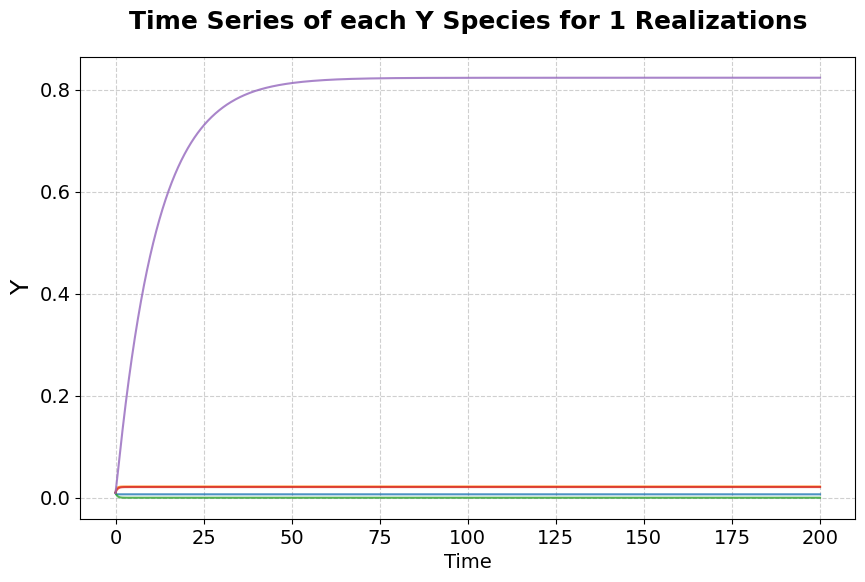

In [12]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [13]:
# Define parameters
ttot3 = 200.0  # Total simulation time
dt3 = 1.0E-3  # Timestep
REALIZATIONS3 = 1  # Number of simulation runs
N_X3 = 4  # Number of original species
N_Y3 = 4  # Number of invaders
N_RY3 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival6 = Single_Invasion(N_X = N_X3, N_Y = N_Y3, N_RY = N_RY3, ttot = ttot3, dt = dt3, REALIZATIONS = REALIZATIONS3, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
   1  2  3  4  5
1  0  0  0  0  0
2  0  0  0  0  0
3  0  0  0  0  0
4  0  0  0  0  0
5  0 -1  0  0  0
6  1  0 -1 -1 -1
7  0  1 -1 -1  1
8 -1 -1  2  1  0
#Species:  8 # Reactions:  5
#Species:  8 # Reactions:  5
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  2 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set ['C_5', 'C_6']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_7', 'C_8']
	 Reactions in AC:  ['R2', 'R3']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R2: C_5+C_8 ->C_7
			 R3: C_6+C_7 ->2C_8
	 - CPU Time: 0.00 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  1 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set ['C_7']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_6', 'C_8']
	 Reactions in AC:  ['R1', 'R3']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_8 ->C_6
			 R3: C_6+C_7 ->2C_8
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 2
Consumed Time: 0.00 secs.
Saved in output/AC

    Time       Y_1       Y_2       Y_3       Y_4
0  0.000  0.009751  0.010308  0.010387  0.010001
1  0.001  0.009757  0.010410  0.010429  0.009924
2  0.002  0.009763  0.010511  0.010472  0.009847
3  0.003  0.009769  0.010613  0.010514  0.009769
4  0.004  0.009775  0.010714  0.010555  0.009694


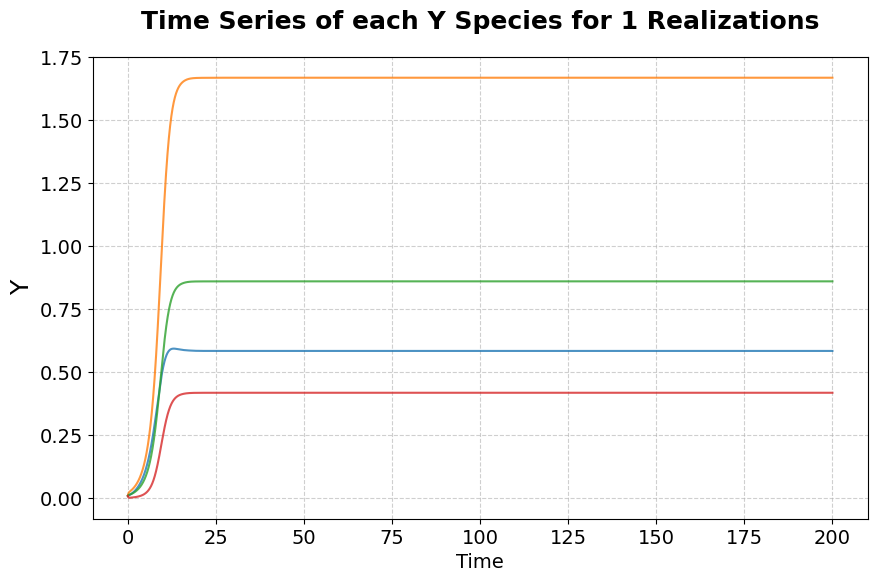

In [14]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Energy Flow

In [15]:
# create output path
output_dir = "output_singleaff"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Affinity(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        Aff_values = []
        
        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term

                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [16]:
# Define parameters
ttot4 = 200.0  # Total simulation time
dt4 = 1.0E-3  # Timestep
REALIZATIONS4 = 1  # Number of simulation runs
N_X4 = 5  # Number of original species
N_Y4 = 5  # Number of invaders
N_RY4 = 8  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff = Single_Invasion_Affinity(N_X = N_X4, N_Y = N_Y4, N_RY = N_RY4, ttot = ttot4, dt = dt4, REALIZATIONS = REALIZATIONS4, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  1  0
2   0  0  0  0 -1  0  0  0
3   1  0  0  0  0  0  0  0
4   0  0 -1  0  1  0  0  0
5   0  0  0  0  0 -1  0  0
6   0  1  1  1 -1  1  0 -1
7  -1  0 -1  0  0  1 -1 -1
8   1  0  0  0  0  0  0  1
9   0 -1  0 -1  1  0  0  0
10  0  0  0  0  0 -1  1  0
#Species:  10 # Reactions:  8
#Species:  10 # Reactions:  8
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  2 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C_2', 'C_7']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_6', 'C_9']
	 Reactions in AC:  ['R2', 'R3', 'R5']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R2: C_9 ->C_6
			 R3: C_4+C_7 ->C_6
			 R5: C_2+C_6 ->C_4+C_9
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  2 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C_2', 'C_7']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_6', 'C_9']
	 Reactions

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5     Aff_6  \
0  0.000 -1.121828 -0.863143  1.668044 -0.863143 -0.205514  2.755802   
1  0.001 -1.113937 -0.861866  1.668160 -0.861866 -0.206790  2.746647   
2  0.002 -1.106037 -0.860600  1.668276 -0.860600 -0.208056  2.737509   
3  0.003 -1.098128 -0.859344  1.668390 -0.859344 -0.209313  2.728386   
4  0.004 -1.090210 -0.858097  1.668504 -0.858097 -0.210559  2.719280   

      Aff_7     Aff_8  
0  0.850648 -3.290034  
1  0.856509 -3.278849  
2  0.862365 -3.267666  
3  0.868215 -3.256485  
4  0.874060 -3.245305  


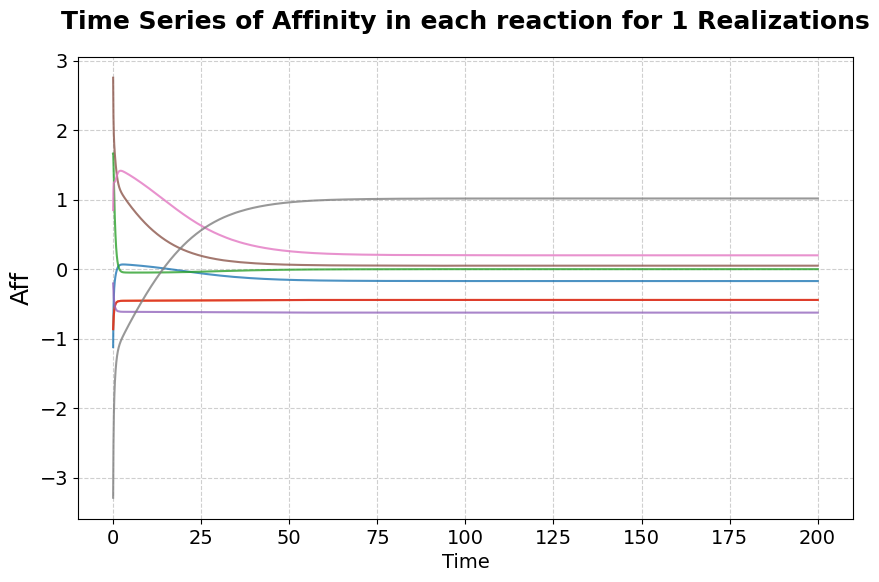

In [17]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [18]:
# Define parameters
ttot4 = 200.0  # Total simulation time
dt4 = 1.0E-3  # Timestep
REALIZATIONS4 = 1  # Number of simulation runs
N_X4 = 15  # Number of original species
N_Y4 = 10  # Number of invaders
N_RY4 = 20  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff = Single_Invasion_Affinity(N_X = N_X4, N_Y = N_Y4, N_RY = N_RY4, ttot = ttot4, dt = dt4, REALIZATIONS = REALIZATIONS4, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
1    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   
4    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5    0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   
6    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
7    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   1   
9    1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
11   0   0   0   0  -1   0   0   0   0   0   0   0   1   0   1   0   0   0   
12  -1   0   0   0   0   0   0   0   0   0   0   

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5     Aff_6  \
0  0.000 -1.642666 -0.326760  0.880161 -2.534225 -0.163352 -0.634398   
1  0.001 -1.605619 -0.332603  0.864833 -2.554633 -0.146691 -0.630302   
2  0.002 -1.569449 -0.338245  0.849645 -2.574924 -0.130189 -0.626280   
3  0.003 -1.534184 -0.343682  0.834636 -2.595066 -0.113884 -0.622335   
4  0.004 -1.499463 -0.348980  0.819627 -2.615204 -0.097593 -0.618433   

      Aff_7     Aff_8     Aff_9  ...    Aff_11    Aff_12    Aff_13    Aff_14  \
0  6.293822  1.784412 -0.604232  ...  3.497902  0.642900  1.268478  6.058936   
1  6.283449  1.760014 -0.589054  ...  3.514142  0.627572  1.248084  6.033655   
2  6.273118  1.735921 -0.574028  ...  3.530288  0.612384  1.227862  6.008740   
3  6.262824  1.712172 -0.559198  ...  3.546301  0.597375  1.207847  5.984242   
4  6.252578  1.688552 -0.544367  ...  3.562349  0.582366  1.187866  5.959898   

     Aff_15    Aff_16    Aff_17    Aff_18    Aff_19    Aff_20  
0 -0.157917 -0.102648 

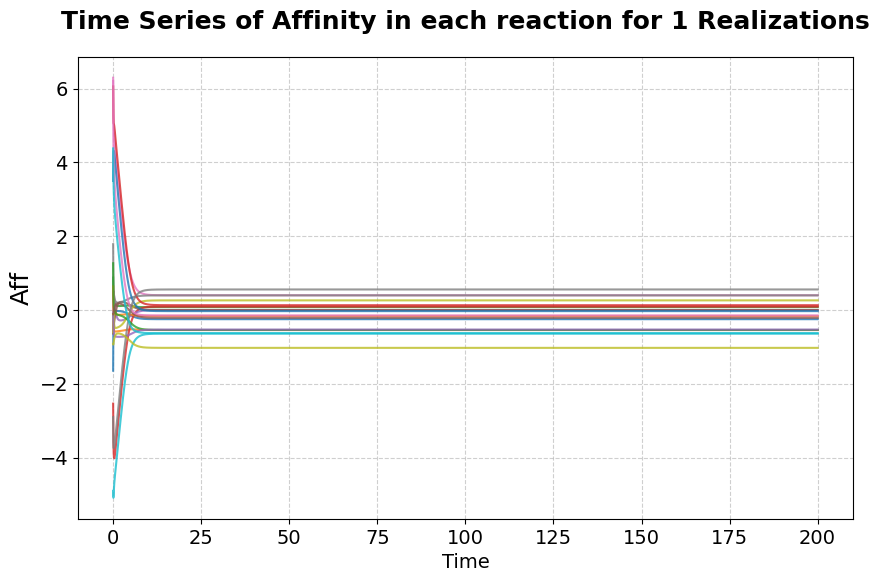

In [19]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3       Y_4       Y_5       Y_6  \
0  0.000  0.010330  0.010147  0.009501  0.010026  0.009797  0.010266   
1  0.001  0.010312  0.010171  0.009366  0.009875  0.009839  0.010493   
2  0.002  0.010294  0.010195  0.009234  0.009727  0.009881  0.010716   
3  0.003  0.010277  0.010217  0.009105  0.009583  0.009923  0.010936   
4  0.004  0.010259  0.010240  0.008978  0.009440  0.009964  0.011154   

        Y_7       Y_8       Y_9      Y_10  
0  0.010318  0.010354  0.010164  0.009860  
1  0.010382  0.010364  0.010267  0.009860  
2  0.010444  0.010375  0.010369  0.009860  
3  0.010506  0.010384  0.010470  0.009858  
4  0.010568  0.010394  0.010570  0.009857  


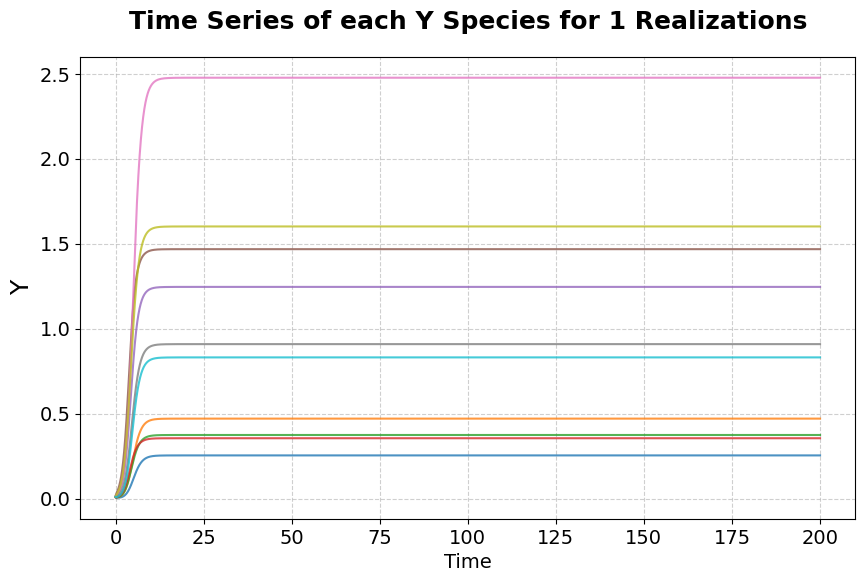

In [20]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Eliminate the chemical potential difference of species x

In [21]:
# create output path
output_dir = "output_singleaff5"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Affinity(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        print(f"X concentration = {X}")
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [0 for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y

        print(f"mu_0={mu_0}")

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        print(f"DeltaG0={DeltaG0}")
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        Aff_values = []
        
        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        print(f"X_values.shape: {X_values.shape}")
        print(f"X concentration: {X_values}")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term
    
                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [22]:
# Define parameters
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 5  # Number of original species
N_Y5 = 5  # Number of invaders
N_RY5 = 10  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff5 = Single_Invasion_Affinity(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [1.9653630454724738, 1.9866450795273762, 2.08376439400558, 1.9451278864731152, 2.001063408508183]
mu_0=[0, 0, 0, 0, 0, 0.5737680978685047, -0.7317796868107784, -0.5529488724168732, 0.772457546553798, 0.3058917767139935]
DeltaG0=[ 1.12671697  0.75163832 -0.75259891 -0.46656577  1.32540642  1.03767146
 -0.48472259 -1.70048507  1.03767146  1.03767146]
Matrix Stot 0:
    1   2   3   4   5   6   7   8   9   10
1    0   0   1   0   0   0   1   0   0   1
2    0   0   0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0   0   0
4    0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0
6    1  -1  -1   0   0   0   0  -2   0   0
7    0   0   1   0   0  -1   1   0  -1  -1
8   -1  -1  -1   0  -1   0  -1   1   0   0
9    0   1   0  -1   1   0   0   0   0   0
10   0   0   0   1   0   1  -1   0   1   1
#Species:  10 # Reactions:  10
#Species:  10 # Reactions:  10
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.0

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5     Aff_6  \
0  0.000 -1.793139 -5.341547 -4.574321  0.496549 -1.293884 -0.946354   
1  0.001 -1.767187 -5.311655 -4.564459  0.498232 -1.260812 -0.924641   
2  0.002 -1.741941 -5.282402 -4.554870  0.499824 -1.228424 -0.903385   
3  0.003 -1.717361 -5.253746 -4.545536  0.501327 -1.196679 -0.882561   
4  0.004 -1.693357 -5.225593 -4.536492  0.502786 -1.165464 -0.861991   

      Aff_7     Aff_8     Aff_9    Aff_10  
0 -4.876445 -2.948202 -0.946354 -1.622031  
1 -4.875388 -2.977336 -0.924641 -1.600318  
2 -4.874532 -3.005716 -0.903385 -1.579062  
3 -4.873866 -3.033385 -0.882561 -1.558238  
4 -4.873492 -3.060451 -0.861991 -1.537668  


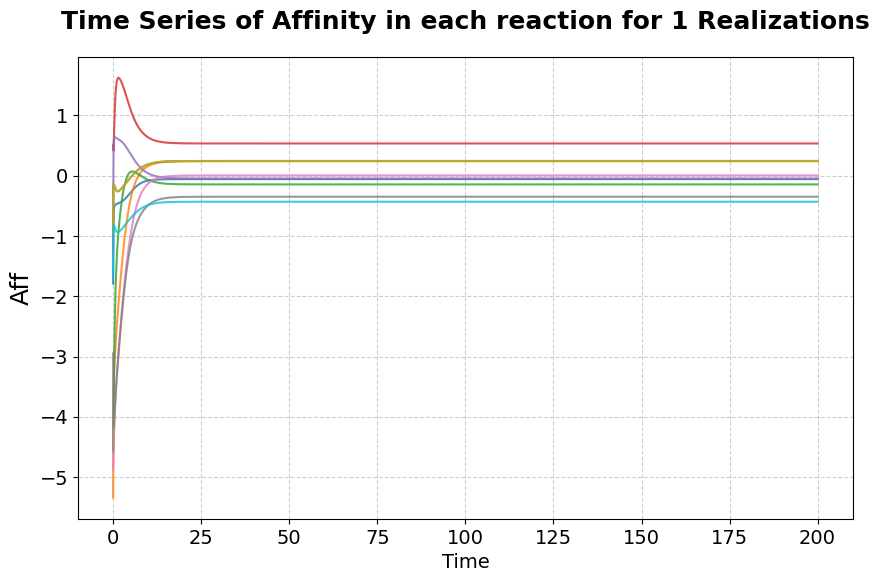

In [23]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3       Y_4       Y_5
0  0.000  0.009839  0.010417  0.010111  0.009797  0.009507
1  0.001  0.009807  0.010518  0.010343  0.009696  0.009394
2  0.002  0.009777  0.010618  0.010575  0.009597  0.009283
3  0.003  0.009747  0.010714  0.010804  0.009499  0.009175
4  0.004  0.009717  0.010809  0.011033  0.009402  0.009068


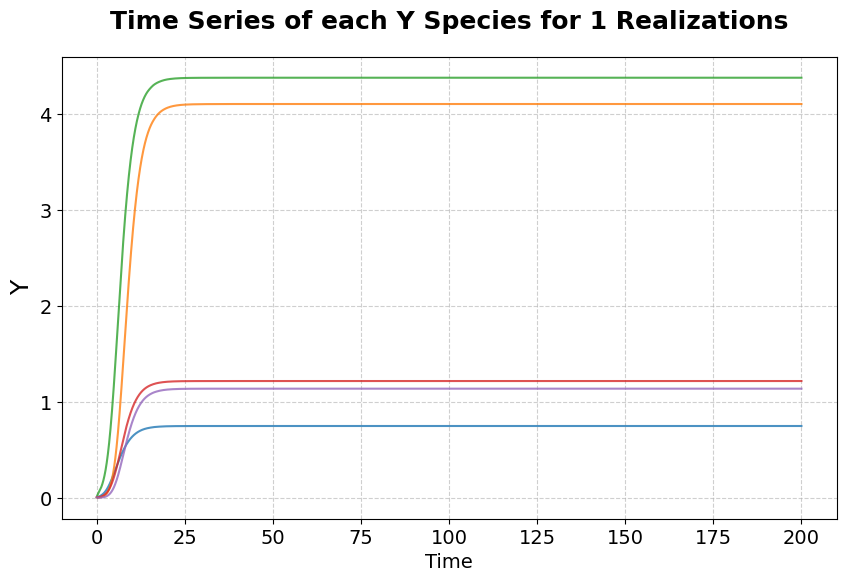

In [24]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [25]:
# Define parameters
# Diluted
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 4  # Number of original species
N_Y5 = 4  # Number of invaders
N_RY5 = 10  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff3 = Single_Invasion_Affinity(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = True, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [1.9685180603882029, 1.9207435539132307, 1.9244356962943527, 2.0642477566281388]
mu_0=[0, 0, 0, 0, 0.8214241031499296, -0.2561886127310653, -0.44814519722635837, -0.8988880593790962]
DeltaG0=[-0.64269945 -1.09084464 -0.64269945 -1.2695693   0.45074286  1.46412355
 -0.45074286  1.72031216 -1.07761272 -1.72031216]
Matrix Stot 0:
   1   2   3   4   5   6   7   8   9   10
1   0   0  -1   0   1   0   0   0   0   0
2   0   0   0  -1   0   0   1   0   0   0
3   0   0   0   0   0   0   0   1   0   0
4  -1  -1   0   0   0   0   0   0   0   0
5   0   0   0  -1   0   1   0   1  -1  -1
6  -1  -1  -1   0   0   1   0   0   1   0
7   0   1   0   1   1   0  -1   0   0   0
8   1   1   1   0  -1  -1   1  -1   0   1
#Species:  8 # Reactions:  10
#Species:  8 # Reactions:  10
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  1 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C_5']
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5     Aff_6  \
0  0.000  1.347199  6.399815  1.299714  1.940820 -1.134734  3.142074   
1  0.001  1.308946  6.358098  1.261461  1.914017 -1.106339  3.203667   
2  0.002  1.272675  6.318378  1.225190  1.887495 -1.079782  3.263011   
3  0.003  1.237675  6.279943  1.190190  1.860802 -1.054449  3.321269   
4  0.004  1.204354  6.243202  1.156869  1.834358 -1.030657  3.377615   

      Aff_7     Aff_8     Aff_9    Aff_10  
0 -0.195259 -2.400193  1.123127  1.745560  
1 -0.223655 -2.344995  1.106183  1.690363  
2 -0.250211 -2.291917  1.089375  1.637284  
3 -0.275544 -2.239891  1.072348  1.585258  
4 -0.299336 -2.189655  1.055434  1.535022  


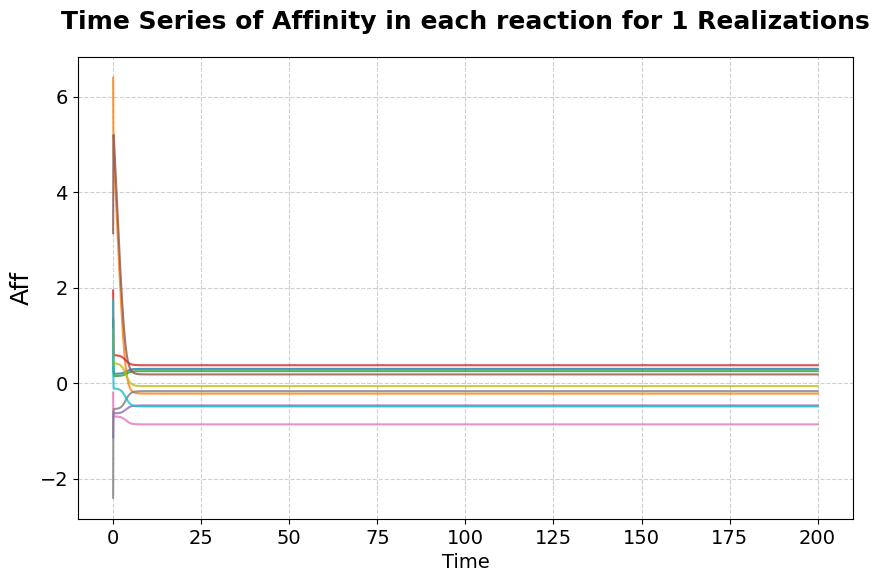

In [26]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Restrict both mu_0 and concentration of X species

In [29]:
# create output path
output_dir = "output_singleaffna1"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Affinity(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 for _ in range(N_X)]
        print(f"X concentration = {X}")
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [0 for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y

        print(f"mu_0={mu_0}")

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        print(f"DeltaG0={DeltaG0}")
        print(f"kr/kf:{np.exp(DeltaG0)}")
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        Aff_values = []
        
        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        # print(f"X_values.shape: {X_values.shape}")
        # print(f"X concentration: {X_values}")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term
    
                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [30]:
# Define parameters
# Diluted
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 3  # Number of original species
N_Y5 = 3  # Number of invaders
N_RY5 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff4 = Single_Invasion_Affinity(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [2.0, 2.0, 2.0]
mu_0=[0, 0, 0, -0.1526999271137357, -0.6145535687933801, 0.6115182717373879]
DeltaG0=[-0.7642182  -1.22607184  1.22607184  0.46185364 -0.7642182 ]
kr/kf:[0.46569787 0.29344301 3.40781676 1.58701301 0.46569787]
Matrix Stot 0:
   1  2  3  4  5
1 -1 -1  0  0 -1
2  0  0 -1  0  0
3  0  0  0  1  0
4  1  0  0  1  1
5  0  1 -1 -1  0
6 -1 -1  1  0 -1
#Species:  6 # Reactions:  5
#Species:  6 # Reactions:  5
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
<bound method NDFrame.head of            Time       Y_1       Y_2       Y_3
0         0.000  0.009978  0.009985  0.010071
1         0.001  0.009994  0.010087  0.009953
2         0.002  0.010010  0.010189  0.009835
3         0.003  0.010025  0.010290  0.009719
4         0.004  0.010039  0.010387  0.009608
...         ...       ...       ...       ...
199995  199.996  0.008744  0.016400  0.004890
199996  199.997  0.008744  0.016400  0.004890
1999

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5
0  0.000  1.466601  1.927723 -0.541429 -1.154269  1.466601
1  0.001  1.453243  1.905790 -0.519496 -1.145694  1.453243
2  0.002  1.439747  1.883819 -0.497524 -1.137219  1.439747
3  0.003  1.426310  1.862059 -0.475764 -1.128896  1.426310
4  0.004  1.413498  1.841218 -0.454924 -1.120867  1.413498


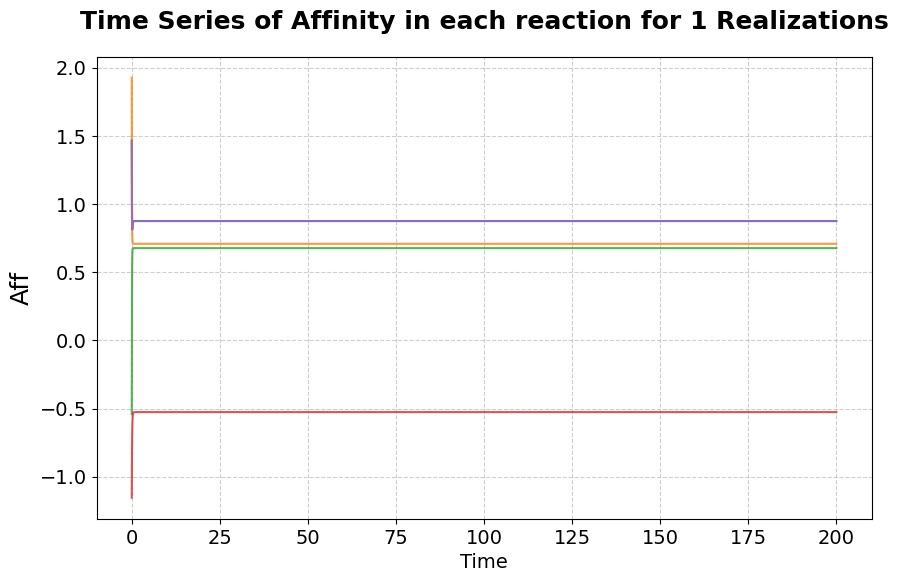

In [31]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3
0  0.000  0.009978  0.009985  0.010071
1  0.001  0.009994  0.010087  0.009953
2  0.002  0.010010  0.010189  0.009835
3  0.003  0.010025  0.010290  0.009719
4  0.004  0.010039  0.010387  0.009608


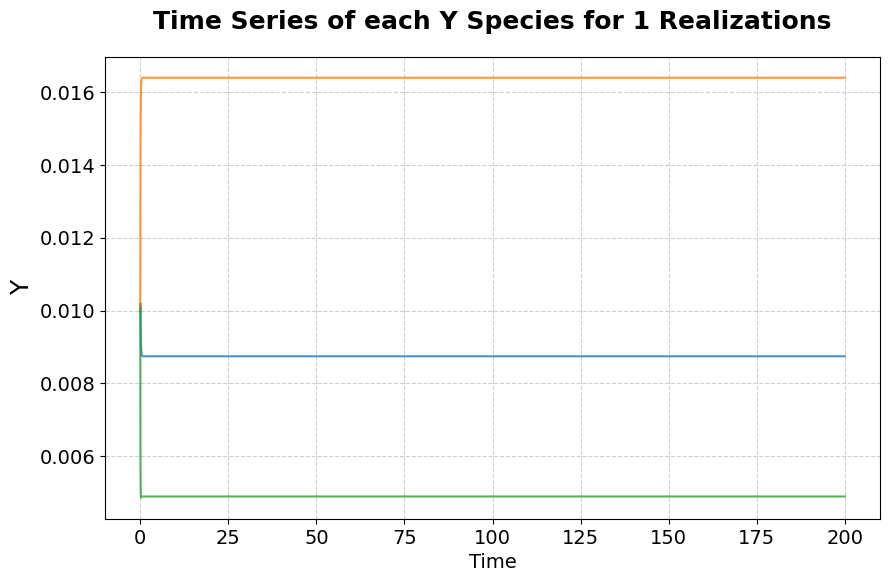

In [32]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [33]:
# Define parameters
# Diluted
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 3  # Number of original species
N_Y5 = 3  # Number of invaders
N_RY5 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff4 = Single_Invasion_Affinity(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = True, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [2.0, 2.0, 2.0]
mu_0=[0, 0, 0, -0.8983474870931087, 0.9331998186595263, -0.07413455958188742]
DeltaG0=[-1.83154731  1.00733438  0.75007837  1.00733438  1.83154731]
kr/kf:[0.16016555 2.73829203 2.11716593 2.73829203 6.24353985]
Matrix Stot 0:
   1  2  3  4  5
1  0  0 -1  0 -1
2  0  0  0  0  0
3  0  0  0  0  0
4  1  0 -1  0 -1
5 -1  1  0  1  1
6  0 -1  2 -1  0
#Species:  6 # Reactions:  5
#Species:  6 # Reactions:  5
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  1 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R1', 'R2', 'R3']
	 Flow:  [0.01] --> Production:  [0.0, 0.01, -0.01]
			 R1: C_5 ->C_4
			 R2: C_6 ->C_5
			 R3: C+C_4 ->2C_6
	 - CPU Time: 0.01 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  1 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C']
	 Waste Set []
	 Extra M in AC:  []
	 Spec

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5
0  0.000  1.880040 -1.063627  4.594110 -1.063627 -1.186893
1  0.001  1.856674 -1.031387  4.569958 -1.031387 -1.163527
2  0.002  1.833138 -0.999156  4.546236 -0.999156 -1.139991
3  0.003  1.810827 -0.968164  4.523109 -0.968164 -1.117680
4  0.004  1.788275 -0.937103  4.500361 -0.937103 -1.095128


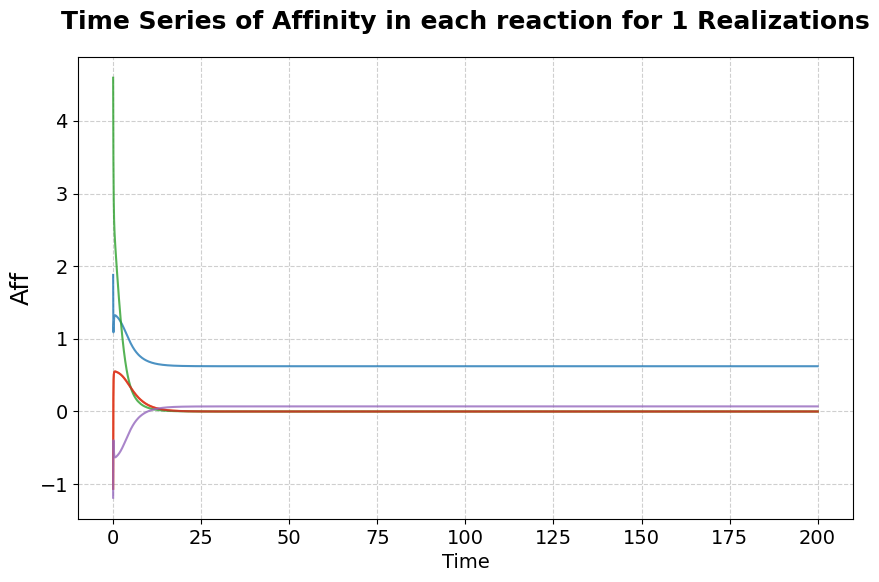

In [34]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3
0  0.000  0.009702  0.010184  0.009626
1  0.001  0.009764  0.010013  0.009775
2  0.002  0.009826  0.009842  0.009923
3  0.003  0.009883  0.009680  0.010067
4  0.004  0.009940  0.009519  0.010211


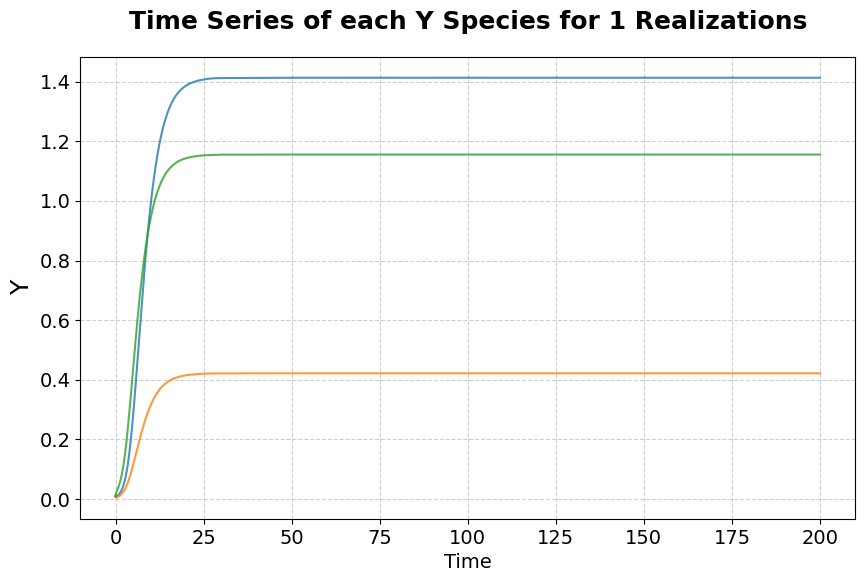

In [35]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Non-automony

In [36]:
# Define parameters
# Diluted
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 3  # Number of original species
N_Y5 = 3  # Number of invaders
N_RY5 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff4 = Single_Invasion_Affinity(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = False, degradation=False)

X concentration = [2.0, 2.0, 2.0]
mu_0=[0, 0, 0, -0.6799614166090213, 0.22571015380424675, -0.2855029293809752]
DeltaG0=[ 0.45425126  0.67996142  0.51121308 -0.39445849  0.05979278]
kr/kf:[1.57499369 1.97380157 1.66731256 0.67404494 1.06161653]
Matrix Stot 0:
   1  2  3  4  5
1  1  1  0  0  1
2  1  0  0  0  0
3  0  0  1 -1  0
4 -1 -1  0  1  0
5 -1  0  1  0 -1
6  0  0 -1 -1 -1
#Species:  6 # Reactions:  5
#Species:  6 # Reactions:  5
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
<bound method NDFrame.head of            Time       Y_1       Y_2       Y_3
0         0.000  0.010275  0.009936  0.009569
1         0.001  0.030644  0.026527  0.013976
2         0.002  0.050959  0.043011  0.018494
3         0.003  0.071221  0.059388  0.023123
4         0.004  0.091429  0.075658  0.027861
...         ...       ...       ...       ...
199995  199.996  5.651955  0.946761  2.310096
199996  199.997  5.651955  0.946761  2.310096
199

    Time      Aff_1     Aff_2     Aff_3     Aff_4      Aff_5
0  0.000 -11.030186 -5.951124 -1.241914  1.016442 -10.013744
1  0.001  -8.955480 -4.858437 -1.845184  0.302504  -8.652976
2  0.002  -7.963584 -4.349844 -2.048390  0.074009  -7.889576
3  0.003  -7.306173 -4.015078 -2.147636 -0.037360  -7.343533
4  0.004  -6.814274 -3.765304 -2.203355 -0.100725  -6.914999


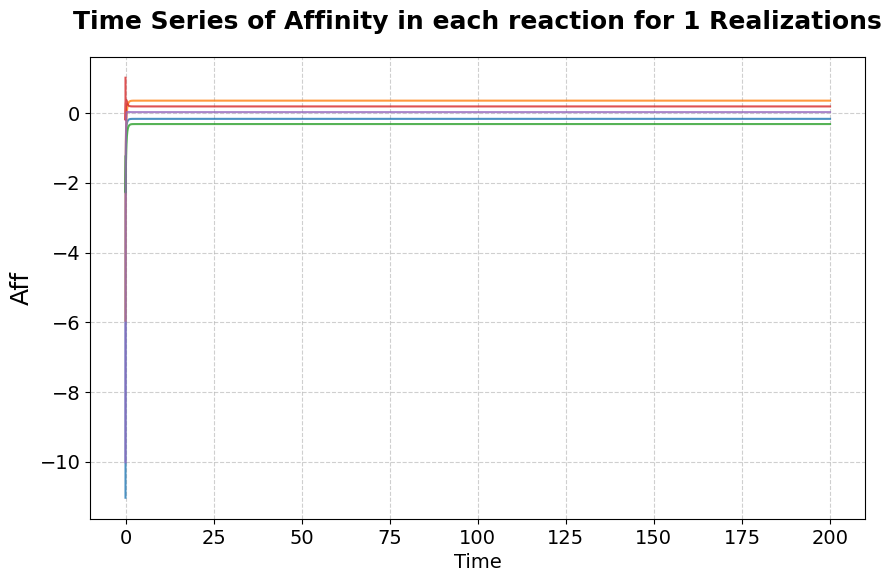

In [37]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3
0  0.000  0.010275  0.009936  0.009569
1  0.001  0.030644  0.026527  0.013976
2  0.002  0.050959  0.043011  0.018494
3  0.003  0.071221  0.059388  0.023123
4  0.004  0.091429  0.075658  0.027861


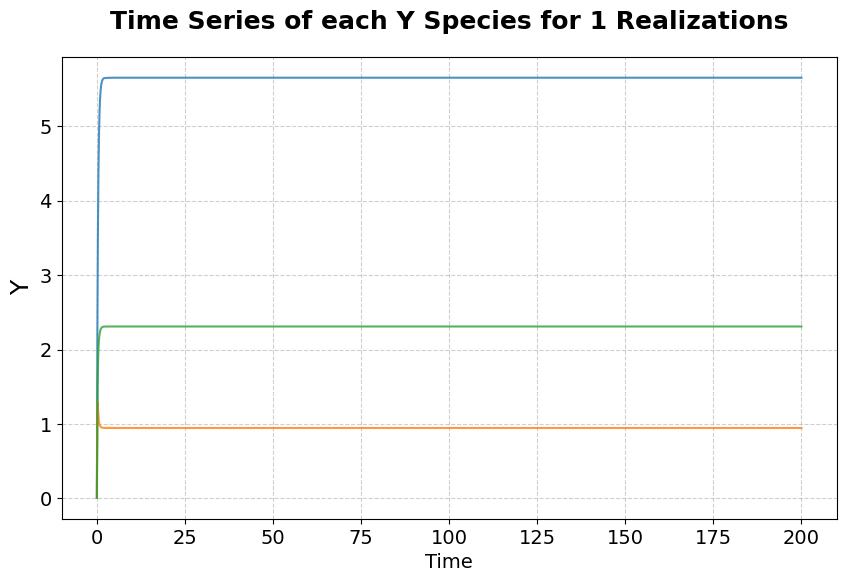

In [38]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## We cna see that only fixing X concentration and chemical potential is not enough to force the whole reaction network to show equilibrium behavior, we need to find a way to fix the total flux to 0, and see if there still have y species growing.

## But here the question is: the flux is defined as a time dependent variable, we need to force it as 0 as initial condition to see if invading species Y will change or not. 

### Firstly, try to generate 0 flux as initial condition at time 0

In [ ]:
# Rejection Sampling
def constraint(values):
    return ()#constraint conditions

def generate_constrained_random(n, low, high, constraint_func, max_attempts=10000):
    for _ in range(max_attempts):
        values = [random.uniform(low, high) for _ in range(n)]
        if constraint_func(values):
            return values
    raise ValueError("unable to generate random numbers under the constraint")

# fix later




### It seems a little bit hard to realize, let's calculate chemical work first  
total chemical work = sigma (external current of x * chemical potential of x)   
As our chemmostatted species is open and non-driven, based on equation 10:  
the external current for species x = - Stoichiometric number * current in a reation which x is engaging 

In [56]:
# create output path
output_dir = "output_chemical_work2"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Aff_Work(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        print(f"X concentration = {X}")
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [random.uniform(-1, 1) for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y
        print(f"mu_0={mu_0}")

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        print(f"DeltaG0={DeltaG0}")
        print(f"kr/kf:{np.exp(DeltaG0)}")
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []

        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        # print(f"X_values.shape: {X_values.shape}")
        # print(f"X concentration: {X_values}")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        Chem_work = []
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            curr2 = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term

                # Safe subtraction with check for NaN or Inf
                curr2[l] = ratef2[l] - rater2[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr2[l]) or np.isinf(curr2[l]):
                    curr2[l] = 0.0

                #Chemical work calculation
                Curr_ext = np.zeros(N_X)
                for i in range(N_X):
                    Curr_ext[i] = - np.dot(Stot[i, :], curr2)
                Work = np.dot(mu_0_X, Curr_ext)
    
                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan

            Chem_work.append(Work.copy())
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)
        Chem_work = np.array(Chem_work)

        columns = ['Time'] + ['Chemwork']
        df_Chemwork = pd.DataFrame(np.column_stack((sol.t, Chem_work)), columns=columns)
        print(df_Chemwork.head)
        file_path = os.path.join(output_dir, f"Chemwork.dat")
        df_Chemwork.to_csv(file_path, sep=" ", index=False, header=True)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [40]:
# Define parameters
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 3  # Number of original species
N_Y5 = 3  # Number of invaders
N_RY5 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_0 = Single_Invasion_Aff_Work(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = False, degradation=False)

X concentration = [2.0, 2.0, 2.0]
mu_0=[0, 0, 0, -0.79902659382039, -0.17561476062156833, -0.9920621634486175]
DeltaG0=[0.62341183 0.17561476 0.17561476 0.17561476 0.35122952]
kr/kf:[1.86528123 1.19197877 1.19197877 1.19197877 1.4208134 ]
Matrix Stot 0:
   1  2  3  4  5
1 -1  1  1  0  0
2  0  0  0  1  0
3  0  1  1  0  1
4 -1  0  0  0  0
5  1 -1 -1 -1 -2
6  0  0  0  0  0
#Species:  6 # Reactions:  5
#Species:  6 # Reactions:  5
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
<bound method NDFrame.head of            Time       Y_1       Y_2       Y_3
0         0.000  0.010170  0.009998  0.010217
1         0.001  0.010232  0.045146  0.010217
2         0.002  0.010425  0.079937  0.010217
3         0.003  0.010747  0.114368  0.010217
4         0.004  0.011196  0.148431  0.010217
...         ...       ...       ...       ...
199995  199.996  2.158785  2.314702  0.010217
199996  199.997  2.158785  2.314702  0.010217
199997  1

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5
0  0.000  0.408591  0.120861  0.287731  3.752859  0.405416
1  0.001  0.410060  0.116534  0.293527  3.744022  0.399620
2  0.002  0.411523  0.112201  0.299322  3.735196  0.393826
3  0.003  0.412978  0.107864  0.305115  3.726380  0.388033
4  0.004  0.414427  0.103521  0.310906  3.717574  0.382241


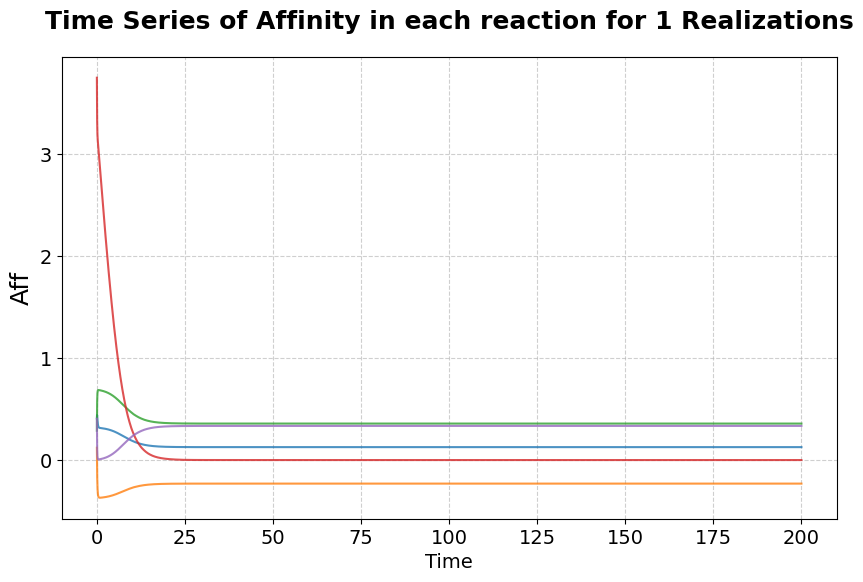

In [57]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time  Chemwork
0  0.000       0.0
1  0.001       0.0
2  0.002       0.0
3  0.003       0.0
4  0.004       0.0


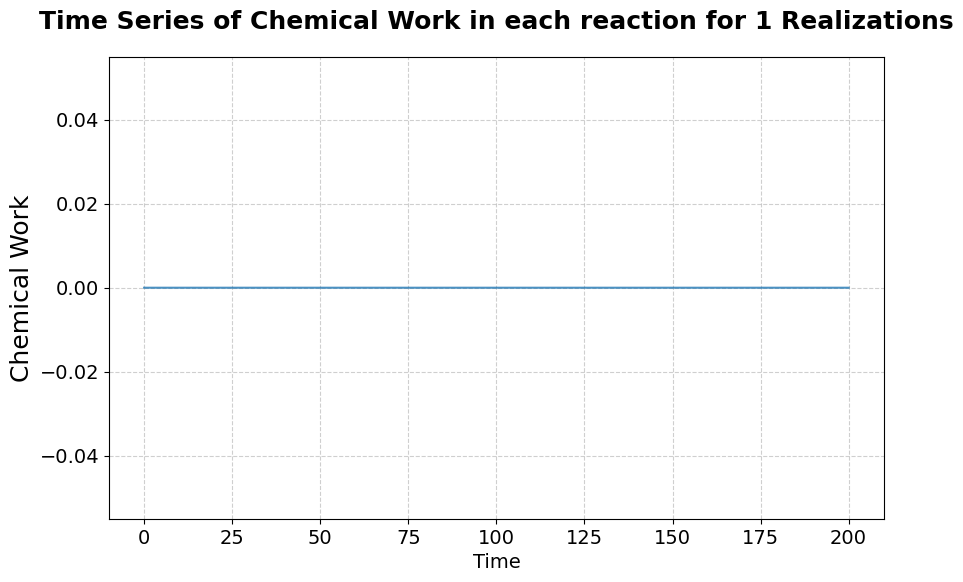

In [42]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Chemwork.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
#file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_work = []
for file in file_list:
    data_work = pd.read_csv(file, sep=' ', header=0)
    print(data_work.head())
    time = data_work['Time']
    for col in data_work.columns:
        if col != 'Time':
            plt.plot(time, data_work[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Chemical Work in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Chemical Work', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Chemwork.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## This is beacuse all our x species chemical poteintial is 0

In [58]:
# Define parameters
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 3  # Number of original species
N_Y5 = 3  # Number of invaders
N_RY5 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_2 = Single_Invasion_Aff_Work(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [1.9678620696762914, 2.052522604773455, 1.9074733455298285]
mu_0=[0.3347518184088394, -0.4186457865957043, 0.29534991325178117, -0.7204703689038303, 0.15013285472388538, 0.784951125646556]
DeltaG0=[ 2.70901841 -2.29037262  0.72538617 -0.0856521   1.02073608]
kr/kf:[15.01453012  0.10122873  2.06552858  0.91791352  2.7752368 ]
Matrix Stot 0:
   1  2  3  4  5
1  0  0  0  0  0
2 -1  0  0  0  0
3  0  0 -1  0  0
4 -1  1 -1  1 -1
5  0  0  2 -1  2
6  2 -2  0  1  0
#Species:  6 # Reactions:  5
#Species:  6 # Reactions:  5
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C_6']
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5']
	 Reactions in AC:  ['R4', 'R5']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R4: C_5 ->C_4+C_6
			 R5: C_4 ->2C_5
	 - CPU Time: 0.00 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  1 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5
0  0.000  2.700040 -2.399616  4.658336  4.623676  3.717206
1  0.001  2.672141 -2.371717  4.630331  4.631363  3.689202
2  0.002  2.644386 -2.343962  4.602473  4.639108  3.661344
3  0.003  2.616770 -2.316346  4.574757  4.646911  3.633628
4  0.004  2.589802 -2.289378  4.547944  4.654406  3.606815


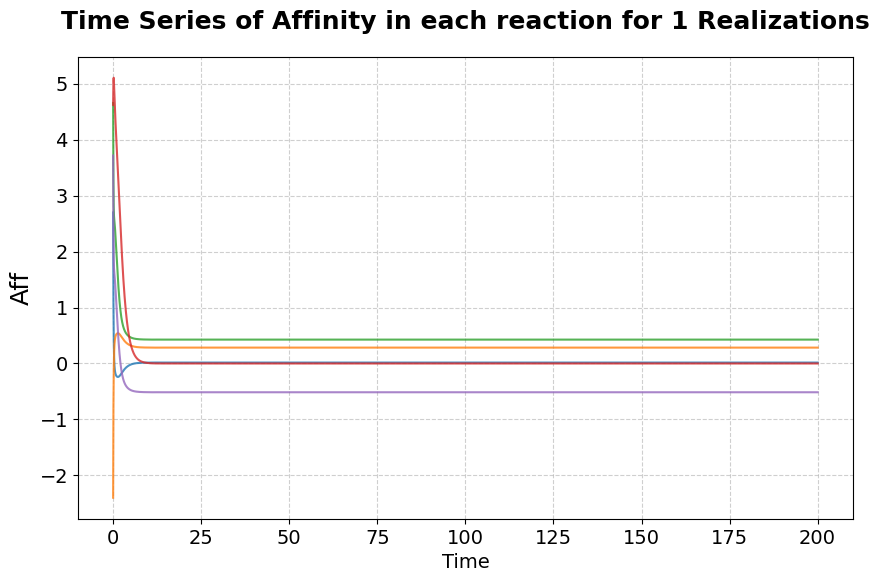

In [59]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time  Chemwork
0  0.000 -0.004775
1  0.001 -0.004708
2  0.002 -0.004642
3  0.003 -0.004574
4  0.004 -0.004509


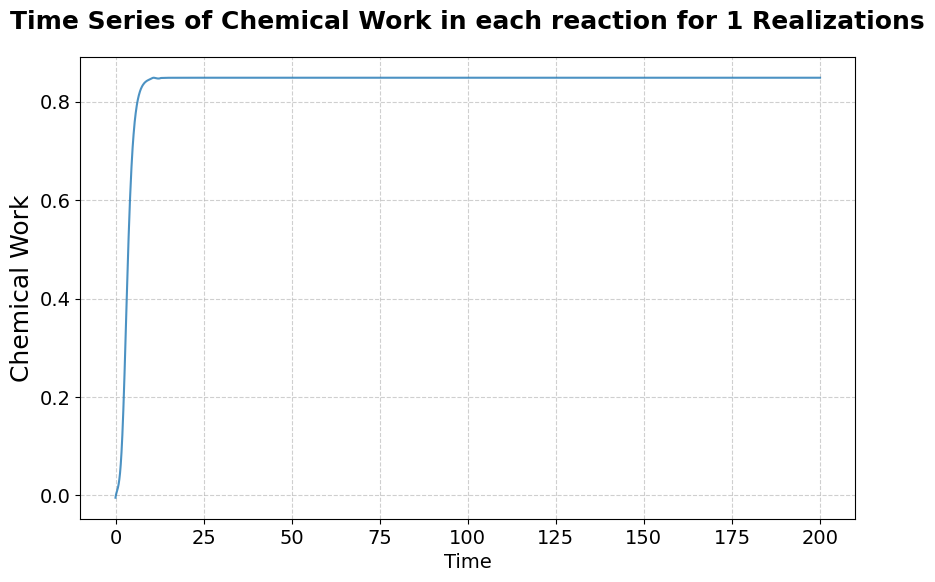

In [60]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Chemwork.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
#file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_work = []
for file in file_list:
    data_work = pd.read_csv(file, sep=' ', header=0)
    print(data_work.head())
    time = data_work['Time']
    for col in data_work.columns:
        if col != 'Time':
            plt.plot(time, data_work[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Chemical Work in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Chemical Work', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Chemwork.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3
0  0.000  0.010170  0.009998  0.010217
1  0.001  0.010232  0.045146  0.010217
2  0.002  0.010425  0.079937  0.010217
3  0.003  0.010747  0.114368  0.010217
4  0.004  0.011196  0.148431  0.010217


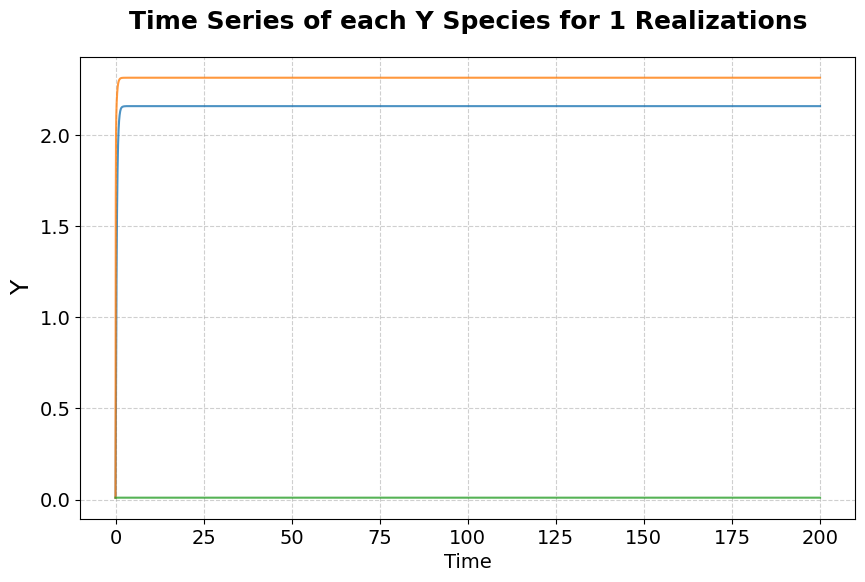

In [43]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Try a larger one

In [44]:
# create output path
output_dir = "output_chemical_work8"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Aff_Work(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        print(f"X concentration = {X}")
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [random.uniform(-1, 1) for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y
        print(f"mu_0={mu_0}")

        '''
        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]
        '''

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        print(f"DeltaG0={DeltaG0}")
        print(f"kr/kf:{np.exp(DeltaG0)}")
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []

        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        # print(f"X_values.shape: {X_values.shape}")
        # print(f"X concentration: {X_values}")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        Chem_work = []
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            curr2 = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term

                # Safe subtraction with check for NaN or Inf
                curr2[l] = ratef2[l] - rater2[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr2[l]) or np.isinf(curr2[l]):
                    curr2[l] = 0.0

                #Chemical work calculation
                Curr_ext = np.zeros(N_X)
                for i in range(N_X):
                    Curr_ext[i] = - np.dot(Stot[i, :], curr2)
                Work = np.dot(mu_0_X, Curr_ext)
    
                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan

            Chem_work.append(Work.copy())
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)
        Chem_work = np.array(Chem_work)

        columns = ['Time'] + ['Chemwork']
        df_Chemwork = pd.DataFrame(np.column_stack((sol.t, Chem_work)), columns=columns)
        print(df_Chemwork.head)
        file_path = os.path.join(output_dir, f"Chemwork.dat")
        df_Chemwork.to_csv(file_path, sep=" ", index=False, header=True)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [49]:
# Define parameters
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 15  # Number of original species
N_Y5 = 10  # Number of invaders
N_RY5 = 20  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_1 = Single_Invasion_Aff_Work(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [2.0558555856965723, 2.0167970701984776, 1.9735320686058748, 2.058408587890572, 2.082152649662326, 1.9237798615071622, 2.024924626324125, 2.052761882932823, 2.017622870648654, 2.0500633525841643, 2.0741280267890914, 2.0281831411958673, 1.9155477316174203, 1.9301008538287105, 2.036326008949933]
mu_0=[0.4964681898094332, 0.18184744853334567, -0.6982502531981594, -0.968091397458857, -0.3257093386978247, 0.8527814131735556, -0.14506889359671438, 0.7323463694187562, 0.9153119153873983, 0.3287778736304279, 0.0016148160696440872, 0.26262655454785966, 0.667999637141818, 0.559472042954624, -0.5456121322737859, 0.34005502971893486, 0.2629452796555265, 0.020664620657758537, 0.7027172456578226, -0.7663963549361921, -0.07792224276140125, -0.05631560159431337, 0.7297299691012102, 0.4760825944017617, 0.5343822738634572]
DeltaG0=[-0.87873292  1.49612632  0.1627436  -1.01988721 -1.02852914 -0.78063949
  0.99229214  0.05829968 -0.52831943  0.5963188   0.75903285  1.10634883
 -0.0151974

    Time  Chemwork
0  0.000  0.202452
1  0.001  0.200937
2  0.002  0.199440
3  0.003  0.198008
4  0.004  0.196581


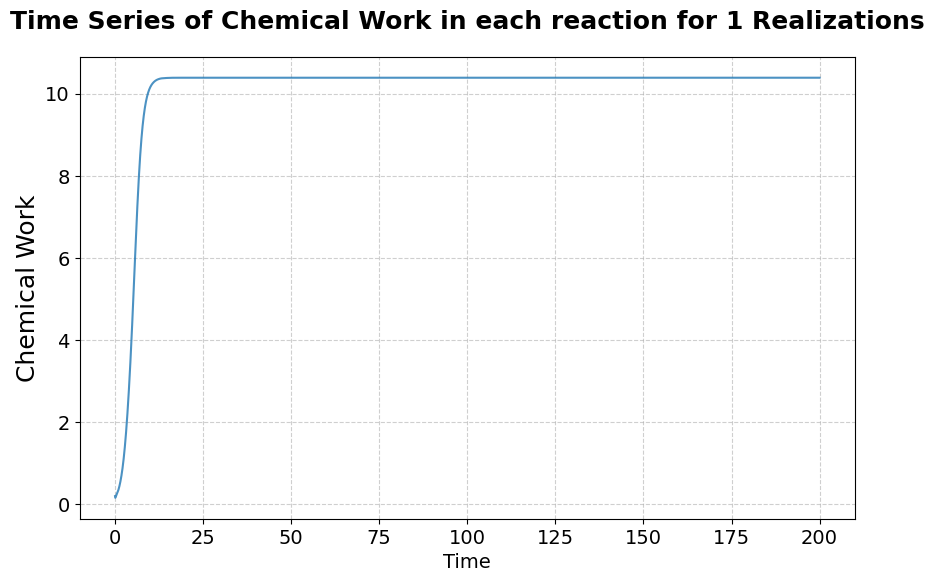

In [50]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Chemwork.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
#file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_work = []
for file in file_list:
    data_work = pd.read_csv(file, sep=' ', header=0)
    print(data_work.head())
    time = data_work['Time']
    for col in data_work.columns:
        if col != 'Time':
            plt.plot(time, data_work[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Chemical Work in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Chemical Work', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Chemwork.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time     Aff_1     Aff_2     Aff_3     Aff_4     Aff_5     Aff_6  \
0  0.000  1.521092 -1.460462  5.169494  1.005318 -3.578050  0.747172   
1  0.001  1.499539 -1.440850  5.159829  0.977549 -3.584342  0.737690   
2  0.002  1.478463 -1.421366  5.150231  0.950245 -3.590478  0.728301   
3  0.003  1.458251 -1.402301  5.141047  0.923968 -3.596292  0.719316   
4  0.004  1.438349 -1.383273  5.131832  0.897941 -3.602007  0.710337   

      Aff_7     Aff_8     Aff_9  ...    Aff_11    Aff_12    Aff_13    Aff_14  \
0 -1.707140 -0.062811 -0.181585  ... -0.731791 -0.339479 -5.240927  1.709105   
1 -1.679582 -0.050326 -0.178850  ... -0.707502 -0.329997 -5.241279  1.684816   
2 -1.652507 -0.038003 -0.176157  ... -0.683734 -0.320608 -5.241727  1.661047   
3 -1.626519 -0.025866 -0.173690  ... -0.661055 -0.311623 -5.241923  1.638369   
4 -1.600789 -0.013877 -0.171216  ... -0.638679 -0.302644 -5.242304  1.615993   

     Aff_15    Aff_16    Aff_17    Aff_18    Aff_19    Aff_20  
0 -0.136036  3.893317 

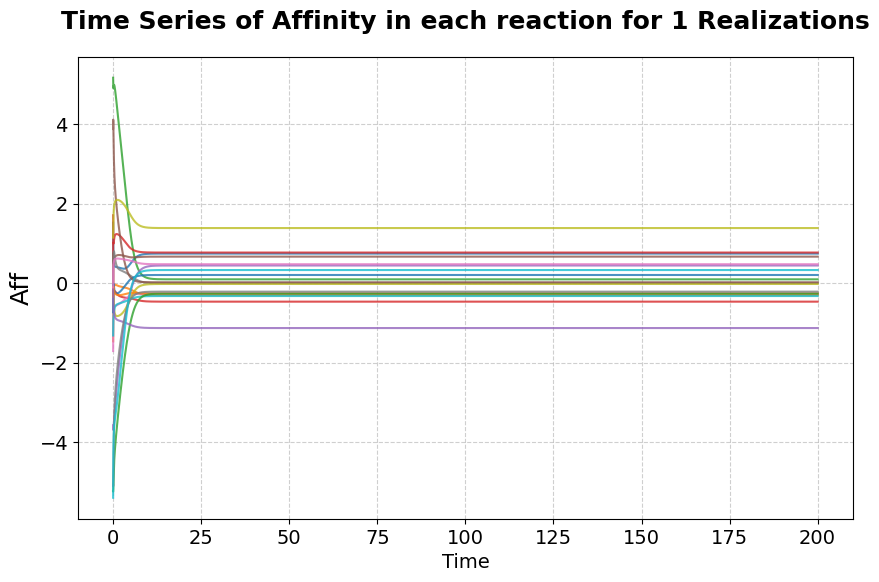

In [51]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Aff_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_aff = []
for file in file_list:
    data_aff = pd.read_csv(file, sep=' ', header=0)
    print(data_aff.head())
    time = data_aff['Time']
    for col in data_aff.columns:
        if col != 'Time':
            plt.plot(time, data_aff[col], linewidth=1.5, alpha=0.8, label=col)
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aff', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()